#  Recycler Simulation

In [24]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('talk')

import copy

from scipy.constants import c, e, m_p

import PyHEADTAIL

from FERMImachines import RR

In [25]:
Q_x = 25.4601
Q_y = 24.412

In [26]:
machine = RR(n_segments=1, machine_configuration='53MHz', 
             longitudinal_focusing='non-linear')

C = machine.circumference

epsn_x = epsn_y = 2.5e-6 # in [m rad]

bunch = machine.generate_6D_Gaussian_bunch_matched(
    n_macroparticles=int(1e3), intensity=1e12, 
    epsn_x=epsn_x, epsn_y=epsn_y, sigma_z=0.2)

Synchrotron init. From kwargs: n_segments = 1
Synchrotron init. From kwargs: machine_configuration = '53MHz'
Synchrotron init. From kwargs: longitudinal_focusing = 'non-linear'
*** Maximum RMS bunch length 0.889766948349279m.
... distance to target bunch length: -1.9516e-01
... distance to target bunch length: 6.6519e-01
... distance to target bunch length: 2.3116e-01
... distance to target bunch length: -1.1321e-02
... distance to target bunch length: -8.3438e-05
... distance to target bunch length: -7.9837e-08
... distance to target bunch length: 9.4652e-07
--> Bunch length: 0.19999992016304485
--> Emittance: 0.00875092415125835


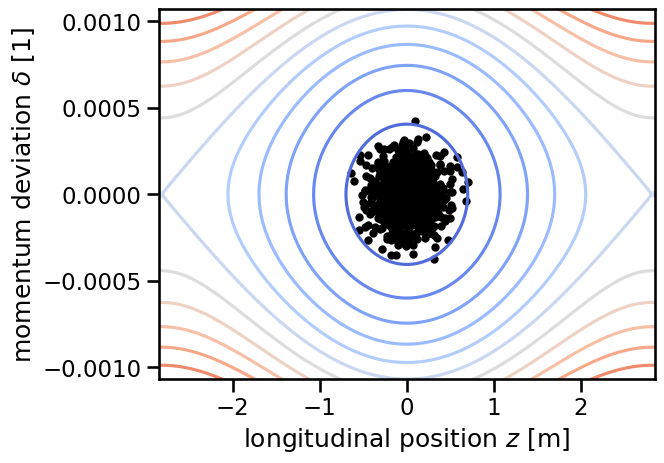

In [27]:
rfsystems = machine.longitudinal_map
rfbucket = rfsystems.get_bucket(bunch)

zz = np.linspace(*rfbucket.interval, num=1000)
dp_max = rfbucket.separatrix(0)
dpp = np.linspace(-dp_max*1.1, dp_max*1.1, num=100)
ZZ, DPP = np.meshgrid(zz, dpp)
HH = rfbucket.hamiltonian(ZZ, DPP)

plt.scatter(bunch.z, bunch.dp, marker='.', color='black')
plt.contour(ZZ, DPP, HH, 15, cmap=plt.get_cmap('coolwarm'))
plt.xlim(rfbucket.interval)
plt.ylim(-dp_max, dp_max)
plt.xlabel('longitudinal position $z$ [m]')
plt.ylabel('momentum deviation $\delta$ [1]');

#### Include Wake Fields

In [28]:
from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.impedances.wakes import CircularResistiveWall, CircularResonator, WakeField

# A method of longitudinal binning for the particle distrubution
# It splits the bunch into 60 slices within the z_cuts range
slicer = UniformBinSlicer(60, z_cuts=(-.1, .1))

# Set up the wake fields that affect the beam particles during the simulation
wakes = []
wake = CircularResonator(R_shunt=10e6, frequency=1e9, Q=2) # Resonator impedance that can cause coherent beam oscillations
# Parameters of the shunt impedance, resonant frequency and quality factor of the resonator are given
wakes.append(wake.function_transverse(1)) # The .function_transverse(1) calculates the wake function at a distance of 1m from the wake source
wake = CircularResistiveWall(pipe_radius=5e-2, resistive_wall_length=C*.9, conductivity=3e6, dt_min=1e-3/c, beta=bunch.beta) # Represents resistive wall impedance that can cause incoherent effects like beam energy loss
# Parameters of the pipe radius, resistive wall length, conductivity, minimum time step and beta function are given
wakes.append(wake.function_transverse(1))
# The wake fields are added to the list of wakes.

# Create a wakefield object to represent the collective effect of the wake fields on the bunch
wakefields = WakeField(slicer, wake)

# Get the longitduinal slices of the bunch using the slicer
slices = bunch.get_slices(slicer) 

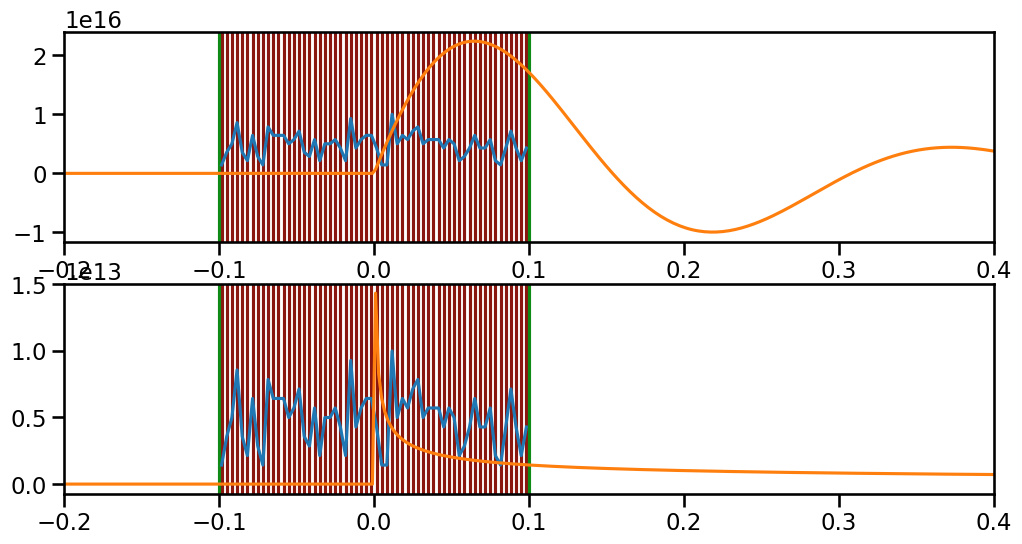

In [29]:
col = sns.hls_palette(6, l=.3, s=.8)

fig, axes = plt.subplots(2, figsize=(12,6))

zz = slices.z_centers
tt = zz/(bunch.beta*c)
t0 = np.linspace(-1, 1, 1000)/(bunch.beta*c)

for i, wk in enumerate(wakes):
    [axes[i].axvline(s, c=col[0]) for s in zz]
    [axes[i].axvline(s, c=col[2]) for s in [slices.z_cut_tail, slices.z_cut_head]]
    axes[i].plot(zz, slices.charge_per_slice*10**[16,13][i]/max(slices.charge_per_slice), '-')
    axes[i].plot(t0*bunch.beta*c, -wk(t0, beta=bunch.beta)[::-1], '-')
    axes[i].set_xlim(-.2, 0.4)

plt.show()

In [30]:
machine.one_turn_map.append(wakefields)

In [31]:
n_turns = 1000

x_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)
y_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)

for i in range(n_turns):
    for m in machine.one_turn_map:
        x_rec[i, :] = bunch.x
        y_rec[i, :] = bunch.y
        m.track(bunch)

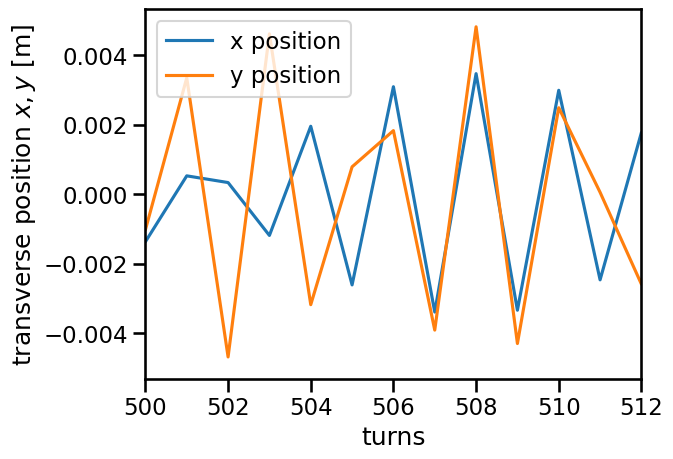

In [32]:
plt.plot(x_rec[:, 0], label='x position')
plt.plot(y_rec[:, 0], label='y position')
plt.legend()
plt.xlim(500, 512)
plt.xlabel('turns')
plt.ylabel('transverse position $x,y$ [m]');

tune freq = 0.46 Hz


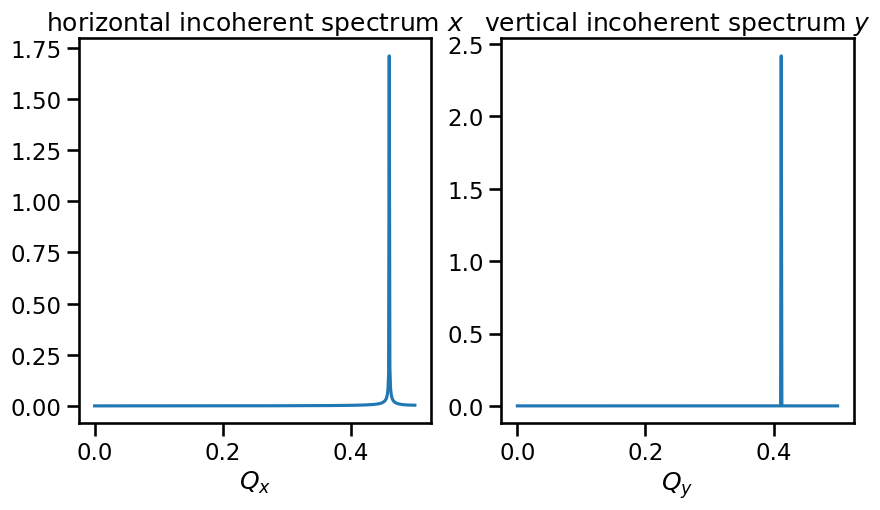

In [33]:
freqs = np.fft.rfftfreq(n_turns)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for x, y in zip(x_rec.T[:1], y_rec.T[:1]):
    ax[0].plot(freqs, np.abs(np.fft.rfft(x)))
    ax[1].plot(freqs, np.abs(np.fft.rfft(y)))
    max_index = np.argmax(np.abs(np.fft.rfft(x)))
    max_freq = freqs[max_index]
    print('tune freq =', max_freq, 'Hz')
ax[0].set_title('horizontal incoherent spectrum $x$')
ax[0].set_xlabel('$Q_x$')
ax[1].set_title('vertical incoherent spectrum $y$')
ax[1].set_xlabel('$Q_y$');

## Effect of changing the intensity on the beam size

*** Maximum RMS bunch length 0.889766948349279m.
... distance to target bunch length: -1.9516e-01
... distance to target bunch length: 6.6519e-01
... distance to target bunch length: 2.3116e-01
... distance to target bunch length: -1.1321e-02
... distance to target bunch length: -8.3438e-05
... distance to target bunch length: -7.9837e-08
... distance to target bunch length: 9.4652e-07
--> Bunch length: 0.19999992016304485
--> Emittance: 0.00875092415125835
*** Maximum RMS bunch length 0.889766948349279m.
... distance to target bunch length: -1.9516e-01
... distance to target bunch length: 6.6519e-01
... distance to target bunch length: 2.3116e-01
... distance to target bunch length: -1.1321e-02
... distance to target bunch length: -8.3438e-05
... distance to target bunch length: -7.9837e-08
... distance to target bunch length: 9.4652e-07
--> Bunch length: 0.19999992016304485
--> Emittance: 0.00875092415125835
*** Maximum RMS bunch length 0.889766948349279m.
... distance to target bunc

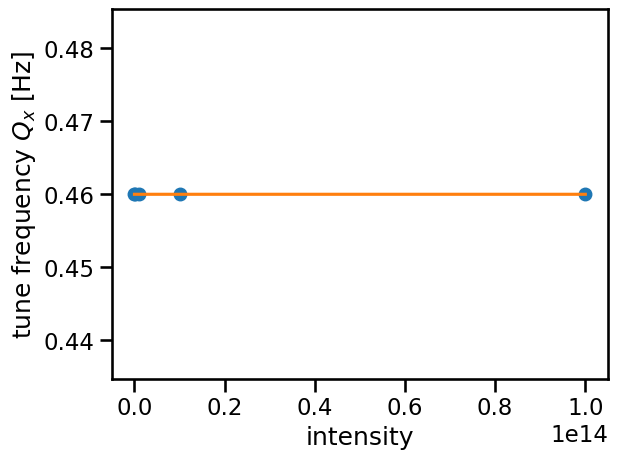

In [34]:
intensities = [1e10, 1e11, 1e12, 1e13, 1e14]
tune_freqs = []

for i, intensity in enumerate(intensities):
    bunch = machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles=int(1e3), intensity=1e12, 
        epsn_x=epsn_x, epsn_y=epsn_y, sigma_z=0.2)
    
    n_turns = 1000

    x_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)
    y_rec = np.empty((n_turns, bunch.macroparticlenumber), dtype=np.float64)

    for i in range(n_turns):
        for m in machine.one_turn_map:
            x_rec[i, :] = bunch.x
            y_rec[i, :] = bunch.y
            m.track(bunch)
    
    freqs = np.fft.rfftfreq(n_turns)
    for x, y in zip(x_rec.T[:1], y_rec.T[:1]):
        ax[0].plot(freqs, np.abs(np.fft.rfft(x)))
        ax[1].plot(freqs, np.abs(np.fft.rfft(y)))
        max_index = np.argmax(np.abs(np.fft.rfft(x)))
        max_freq = freqs[max_index]

    tune_freqs.append(max_freq)


plt.plot(intensities, tune_freqs, 'o')
plt.xlabel('intensity')
plt.ylabel('tune frequency $Q_x$ [Hz]')
a,b = np.polyfit(intensities, tune_freqs, 1)
plt.plot(np.arange(1e10, 1e14, 1e10),  np.arange(1e10, 1e14, 1e10)*a+b, label='linear fit')
plt.show()